In [1]:
import os
import sys
import json
import random
import math
import re
import time
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt
import skimage.draw
import tensorflow as tf

# Root directory of the project
ROOT_DIR = os.path.abspath("../")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log

%matplotlib inline

# GPU checks
print("Using GPU: " + str(tf.test.is_gpu_available()))
print("GPU name: " + str(tf.test.gpu_device_name()))

# Hide some tensorflaw warning messages
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

/home/vic/.local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/vic/.local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/vic/.local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/vic/.local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarnin

Using GPU: True
GPU name: /device:GPU:0


In [2]:
class FashionConfig(Config):
    """Configuration for training on the deepfashion2 dataset.
    Derives from the base Config class and overrides values specific
    to deepfashion2 dataset.
    """
    # Give the configuration a recognizable name
    NAME = "fashion"

    # Train on 1 GPU and 8 images per GPU. We can put multiple images on each
    # GPU because the images are small. Batch size is 8 (GPUs * images/GPU).
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

    # Number of classes (including background)
    NUM_CLASSES = 1 + 13  # background + 3 shapes

    # Use small images for faster training. Set the limits of the small side
    # the large side, and that determines the image shape.
    IMAGE_MIN_DIM = 128
    IMAGE_MAX_DIM = 128

    # Use smaller anchors because our image and objects are small
    RPN_ANCHOR_SCALES = (8, 16, 32, 64, 128)  # anchor side in pixels

    # Reduce training ROIs per image because the images are small and have
    # few objects. Aim to allow ROI sampling to pick 33% positive ROIs.
    TRAIN_ROIS_PER_IMAGE = 32

    # Use a small epoch since the data is simple
    STEPS_PER_EPOCH = 100

    # use small validation steps since the epoch is small
    VALIDATION_STEPS = 5

config = FashionConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  128
IMAGE_META_SIZE                26
IMAGE_MIN_DIM                  128
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [128 128   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE             

## Notebook Preferences

In [3]:
def get_ax(rows=1, cols=1, size=8):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Change the default size attribute to control the size
    of rendered images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

## Dataset

Create a synthetic dataset

Extend the Dataset class and add a method to load the deepfashion2 dataset, `load_fashion()`, and override the following methods:

* load_image()
* load_mask()
* image_reference()

In [4]:
class FashionDataset(utils.Dataset):

    def load_fashion(self, dataset_dir, subset):
        """Load a subset of the deepfashion2 dataset.
        dataset_dir: Root directory of the dataset.
        subset: Subset to load: train or val
        """
        # Add classes. We have only one class to add.
        self.add_class("fashion", 1, "short sleeve top")
        self.add_class("fashion", 2, "long sleeve top")
        self.add_class("fashion", 3, "short sleeve outwear")
        self.add_class("fashion", 4, "long sleeve outwear")
        self.add_class("fashion", 5, "vest")
        self.add_class("fashion", 6, "sling")
        self.add_class("fashion", 7, "shorts")
        self.add_class("fashion", 8, "trousers")
        self.add_class("fashion", 9, "skirt")
        self.add_class("fashion", 10, "short sleeve dress")
        self.add_class("fashion", 11, "long sleeve dress")
        self.add_class("fashion", 12, "vest dress")
        self.add_class("fashion", 13, "sling dress")

        # Train or validation dataset?
        assert subset in ["train", "val"]
        dataset_dir = os.path.join(dataset_dir, subset)
        dataset_dir_image = os.path.join(dataset_dir, 'image')
        dataset_dir_annos = os.path.join(dataset_dir, 'annos_preprocessed')
        
        """
        [
            {
                id,
                width,
                height,
                clothes: [
                    {
                        category_id,
                        segmentations: [
                            {
                                all_x_points: [],
                                all_y_points: [],
                            }
                        ],
                        landmark: {
                            'all_x_points': [],
                            'all_y_points': [],
                            'all_v_points': [],
                        }
                    }
                ]
            }
        ]
        """
        
        
        annotations = json.load(open(os.path.join(dataset_dir_annos, 'annotations.json')))

        # Add images
        for annotation in annotations:
            image_id = annotation['id']
            image_path = os.path.join(dataset_dir_image, image_id + '.jpg')
            
            self.add_image(
                "fashion",
                image_id=image_id,  # use file name as a unique image id
                path=image_path,
                width=annotation['width'],
                height=annotation['height'],
                clothes=annotation['clothes']
            )

    def load_mask(self, image_id):
        """Generate instance masks for an image.
       Returns:
        masks: A bool array of shape [height, width, instance count] with
            one mask per instance.
        landmarks: A int array of shape [height, width, instance count] with
            one landmark per instance.
        class_ids: a 1D array of class IDs of the instance masks.
        """
        # If not a fashion dataset image, delegate to parent class.
        image_info = self.image_info[image_id]
        if image_info["source"] != "fashion":
            return super(self.__class__, self).load_mask(image_id)

        # Convert segmentations to a bitmap mask of shape
        # [height, width, instance_count]
        info = self.image_info[image_id]
        mask = np.zeros([info["height"], info["width"], len(info["clothes"])],
                        dtype=np.uint8)
        landmark = np.zeros([info["height"], info["width"], len(info["clothes"])],
                dtype=np.uint8)
        class_ids = np.zeros(len(info['clothes']), dtype=np.uint8)
        for clothing_idx, cloth in enumerate(info["clothes"]):
            class_ids[clothing_idx] = cloth['category_id']
            for segmentation_idx, segmentation in enumerate(cloth['segmentations']):
                # Get indexes of pixels inside the polygon and set them to 1
                rr, cc = skimage.draw.polygon(
                    segmentation['all_y_points'],
                    segmentation['all_x_points'])
                mask[rr, cc, clothing_idx] = 1
            landmark[
                cloth['landmark']['all_y_points'],
                cloth['landmark']['all_x_points'],
                clothing_idx] = cloth['landmark']['all_v_points']

        # Return mask, and array of class IDs of each instance.
        return mask, class_ids, landmark

    def image_reference(self, image_id):
        """Return the path of the image."""
        info = self.image_info[image_id]
        if info["source"] == "fashion":
            return info["path"]
        else:
            super(self.__class__, self).image_reference(image_id)
            
    def load_image(self, image_id):
        info = self.image_info[image_id]
        return skimage.io.imread(info['path'])

In [5]:
dataset_train = FashionDataset()
dataset_train.load_fashion(ROOT_DIR + '/datasets/big_deepfashion2', "train")
dataset_train.prepare()

dataset_val = FashionDataset()
dataset_val.load_fashion(ROOT_DIR + '/datasets/big_deepfashion2', "val")
dataset_val.prepare()

In [6]:
    #image_ids = np.random.choice(dataset_val.image_ids, 4)
#for image_id in image_ids:
#    image = dataset_val.load_image(image_id)
#    mask, class_ids, landmarks = dataset_val.load_mask(image_id)
#    visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names)

## Create model

In [7]:
# Create model in training mode
model = modellib.MaskRCNN(mode="training", config=config,
                          model_dir=MODEL_DIR)






Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
box_ind is deprecated, use box_indices instead


In [8]:
init_with = "imagenet"

if init_with == "imagenet":
    model.load_weights(model.get_imagenet_weights(), by_name=True)
elif init_with == "last":
    # Load the last model you trained and continue training
    model.load_weights(model.find_last(), by_name=True)

## Training

Train in two stages:
1. Only the heads. Here we're freezing all the backbone layers and training only the randomly initialized layers (i.e. the ones that we didn't use pre-trained weights from MS COCO). To train only the head layers, pass `layers='heads'` to the `train()` function.

2. Fine-tune all layers. For this simple example it's not necessary, but we're including it to show the process. Simply pass `layers="all` to train all layers.

In [9]:
# Train the head branches
# Passing layers="heads" freezes all layers except the head
# layers. You can also pass a regular expression to select
# which layers to train by name pattern.

#Add callbacks for history and early stopping
import keras
earlystop = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1, mode='auto')
history = keras.callbacks.History()

model.train(dataset_train, dataset_val,
            learning_rate=config.LEARNING_RATE, 
            epochs=100,
            layers='heads',
            custom_callbacks = [earlystop, history]
)


Starting at epoch 0. LR=0.001

Checkpoint Path: /home/vic/Desktop/deepfashion-project/Mask_RCNN/logs/fashion20191107T1317/mask_rcnn_fashion_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_landmark_conv1   (TimeDistributed)
mrcnn_landmark_bn1     (TimeDistributed)
mrcnn_landmark_conv2   (TimeDistributed)
mrcnn_landmark_bn2     (TimeDistributed)
mrcnn_landmark_conv3   (TimeDistributed)
mrcnn_landmark_bn3     (TimeDistributed)
mrcnn_landmark_conv4   (TimeDistributed)
mrcnn_landmark_bn4     (TimeDistributed)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_landmark_conv5   (TimeDistributed)
mrcnn_mask_bn1         

/home/vic/.local/lib/python3.7/site-packages/tensorflow/python/ops/gradients_util.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/home/vic/.local/lib/python3.7/site-packages/tensorflow/python/ops/gradients_util.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/home/vic/.local/lib/python3.7/site-packages/tensorflow/python/ops/gradients_util.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/home/vic/.local/lib/python3.7/site-packages/tensorflow/python/ops/gradients_util.py:93: UserWarning: Converting sparse IndexedSlices to a den

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor




/home/vic/.local/lib/python3.7/site-packages/keras/engine/training.py:1987: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'
ERROR:root:Error processing image {'id': '062215', 'source': 'fashion', 'path': '/home/vic/Desktop/deepfashion-project/Mask_RCNN/datasets/big_deepfashion2/train/image/062215.jpg', 'width': 640, 'height': 611, 'clothes': [{'category_id': 1, 'segmentations': [{'all_x_points': [360.71, 341.86, 316.46, 305.92, 285.88, 269.25, 240.56, 227.75, 220.8, 216.66, 227.11, 239.55, 247.47, 252.59, 261.22, 267.07, 273.11, 270.92, 264.47, 267.73, 287.46, 330.62, 415.22, 434.03, 433.3, 438.3, 451.41, 452.94, 467.12, 479.48, 495.04, 492.26, 508.8, 517.6, 523.84, 510.58, 488.21, 449.5, 428.22, 414.56, 387.38], 'all_y_points': [250.64, 246.47, 245.51, 237.77, 237.57, 249.45, 286.72, 302.18, 307.82, 319.08,

Epoch 1/100
 99/100 [============================>.] - ETA: 0s - loss: 5.0864 - rpn_class_loss: 0.2866 - rpn_bbox_loss: 1.9414 - mrcnn_class_loss: 0.6795 - mrcnn_bbox_loss: 0.9747 - mrcnn_mask_loss: 0.6247 - mrcnn_landmark_loss: 0.5796

/home/vic/.local/lib/python3.7/site-packages/keras/engine/training.py:2142: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


100/100 [==============================] - 89s - loss: 5.0832 - rpn_class_loss: 0.2841 - rpn_bbox_loss: 1.9327 - mrcnn_class_loss: 0.6841 - mrcnn_bbox_loss: 0.9762 - mrcnn_mask_loss: 0.6256 - mrcnn_landmark_loss: 0.5805 - val_loss: 4.3993 - val_rpn_class_loss: 0.0378 - val_rpn_bbox_loss: 1.0643 - val_mrcnn_class_loss: 0.9651 - val_mrcnn_bbox_loss: 0.9257 - val_mrcnn_mask_loss: 0.7194 - val_mrcnn_landmark_loss: 0.6870
Epoch 2/100
 93/100 [==========================>...] - ETA: 2s - loss: 4.2436 - rpn_class_loss: 0.0590 - rpn_bbox_loss: 1.4335 - mrcnn_class_loss: 0.6406 - mrcnn_bbox_loss: 0.8458 - mrcnn_mask_loss: 0.6476 - mrcnn_landmark_loss: 0.6171

ERROR:root:Error processing image {'id': '047220', 'source': 'fashion', 'path': '/home/vic/Desktop/deepfashion-project/Mask_RCNN/datasets/big_deepfashion2/train/image/047220.jpg', 'width': 468, 'height': 702, 'clothes': [{'category_id': 7, 'segmentations': [{'all_x_points': [96.2, 99.4, 100.72, 101.89, 104.2, 107.03, 117.2, 154.2, 199.2, 265.8, 301.8, 318.49, 322.2, 320.8, 321.6, 321.6, 319.8, 318.0, 317.0, 316.2, 321.2, 323.4, 321.6, 318.6, 322.6, 326.4, 323.2, 316.8, 297.2, 282.8, 263.4, 250.2, 245.2, 242.2, 239.8, 233.6, 225.6, 215.6, 204.0, 202.2, 202.0, 200.2, 192.2, 187.0, 175.8, 165.4, 161.8, 155.4, 152.0, 147.4, 139.6, 135.8, 132.0, 128.8, 122.4, 115.6, 115.4, 105.8, 97.0, 90.2, 86.2, 83.6, 75.2, 71.6, 74.6, 74.2, 76.2, 83.8, 88.6, 92.8], 'all_y_points': [603.8, 588.0, 575.71, 565.77, 555.8, 549.96, 548.8, 561.2, 566.0, 563.4, 559.2, 559.07, 577.8, 607.6, 614.8, 623.0, 635.2, 645.4, 656.2, 662.8, 668.6, 673.4, 676.6, 678.8, 682.0, 686.6, 693.8, 696.4, 701.2, 701.4, 702.2, 702.2

100/100 [==============================] - 44s - loss: 4.1939 - rpn_class_loss: 0.0579 - rpn_bbox_loss: 1.4012 - mrcnn_class_loss: 0.6381 - mrcnn_bbox_loss: 0.8384 - mrcnn_mask_loss: 0.6443 - mrcnn_landmark_loss: 0.6141 - val_loss: 3.6878 - val_rpn_class_loss: 0.0419 - val_rpn_bbox_loss: 0.9745 - val_mrcnn_class_loss: 0.6334 - val_mrcnn_bbox_loss: 0.6447 - val_mrcnn_mask_loss: 0.7176 - val_mrcnn_landmark_loss: 0.6757
Epoch 3/100
 11/100 [==>...........................] - ETA: 37s - loss: 4.2278 - rpn_class_loss: 0.0462 - rpn_bbox_loss: 1.3394 - mrcnn_class_loss: 0.5994 - mrcnn_bbox_loss: 0.8497 - mrcnn_mask_loss: 0.6991 - mrcnn_landmark_loss: 0.6940

ERROR:root:Error processing image {'id': '099616', 'source': 'fashion', 'path': '/home/vic/Desktop/deepfashion-project/Mask_RCNN/datasets/big_deepfashion2/train/image/099616.jpg', 'width': 468, 'height': 631, 'clothes': [{'category_id': 4, 'segmentations': [{'all_x_points': [61.12, 55.26, 55.26, 52.63, 51.28, 51.91, 50.12, 49.29, 46.89, 49.4, 49.4, 53.59, 60.29, 67.82, 74.09, 87.17, 106.34, 118.06, 143.7, 156.05, 165.47, 178.34, 189.23, 198.44, 201.79, 221.88, 267.1, 303.1, 319.85, 332.99, 348.72, 375.11, 408.49, 436.23, 452.08, 460.51, 466.58, 467.21, 467.21, 468.05, 468.05, 468.05, 468.05, 458.0, 439.58, 423.67, 417.81, 415.3, 405.25, 396.88, 396.88, 398.55, 396.88, 392.58, 382.53, 349.15, 308.53, 290.31, 281.33, 272.96, 260.28, 247.0, 240.3, 242.07, 240.71, 232.77, 231.09, 232.77, 239.47, 238.63, 221.05, 194.25, 184.21, 182.09, 176.16, 161.6, 153.23, 143.18, 137.32, 132.29, 128.94, 133.97, 128.11, 123.92, 123.92, 125.59, 125.59, 123.92, 118.9, 118.06, 116.38, 113.04, 106.42, 101.31,

 81/100 [=======================>......] - ETA: 8s - loss: 3.9960 - rpn_class_loss: 0.0416 - rpn_bbox_loss: 1.1932 - mrcnn_class_loss: 0.6106 - mrcnn_bbox_loss: 0.8072 - mrcnn_mask_loss: 0.6799 - mrcnn_landmark_loss: 0.6635

ERROR:root:Error processing image {'id': '055019', 'source': 'fashion', 'path': '/home/vic/Desktop/deepfashion-project/Mask_RCNN/datasets/big_deepfashion2/train/image/055019.jpg', 'width': 288, 'height': 386, 'clothes': [{'category_id': 1, 'segmentations': [{'all_x_points': [187.8, 190.0, 190.0, 191.0, 196.2, 199.2, 209.4, 222.6, 233.0, 237.0, 237.0, 245.0, 275.0, 279.0, 280.0, 281.4, 277.0, 265.6, 253.0, 252.0, 255.0, 260.0, 258.0, 254.0, 251.6, 252.0, 251.8, 250.2, 240.0, 200.0, 172.0, 155.0, 160.0, 162.8, 158.0, 148.0, 140.0, 142.0, 158.2, 178.2], 'all_y_points': [120.6, 136.0, 141.0, 147.0, 152.8, 157.2, 155.8, 150.4, 139.0, 127.0, 115.0, 118.0, 138.0, 149.0, 162.0, 188.4, 191.0, 190.6, 188.0, 199.0, 234.0, 243.0, 251.0, 264.0, 266.4, 271.0, 277.8, 283.2, 293.0, 290.0, 286.0, 272.0, 224.0, 187.8, 183.0, 181.0, 176.0, 153.0, 133.0, 124.0]}], 'landmark': {'all_x_points': [211, 187, 190, 207, 230, 238, 159, 143, 140, 162, 162, 163, 163, 159, 155, 200, 250, 255, 252, 249, 248, 247, 280

100/100 [==============================] - 45s - loss: 3.9791 - rpn_class_loss: 0.0422 - rpn_bbox_loss: 1.1793 - mrcnn_class_loss: 0.6195 - mrcnn_bbox_loss: 0.8010 - mrcnn_mask_loss: 0.6763 - mrcnn_landmark_loss: 0.6607 - val_loss: 4.7867 - val_rpn_class_loss: 0.0395 - val_rpn_bbox_loss: 1.5146 - val_mrcnn_class_loss: 0.8868 - val_mrcnn_bbox_loss: 0.9687 - val_mrcnn_mask_loss: 0.6937 - val_mrcnn_landmark_loss: 0.6834
Epoch 4/100
100/100 [==============================] - 45s - loss: 3.7619 - rpn_class_loss: 0.0407 - rpn_bbox_loss: 1.2811 - mrcnn_class_loss: 0.5004 - mrcnn_bbox_loss: 0.6795 - mrcnn_mask_loss: 0.6416 - mrcnn_landmark_loss: 0.6186 - val_loss: 4.1908 - val_rpn_class_loss: 0.0466 - val_rpn_bbox_loss: 1.3066 - val_mrcnn_class_loss: 0.5548 - val_mrcnn_bbox_loss: 0.8930 - val_mrcnn_mask_loss: 0.6829 - val_mrcnn_landmark_loss: 0.7068
Epoch 5/100
100/100 [==============================] - 46s - loss: 3.8545 - rpn_class_loss: 0.0416 - rpn_bbox_loss: 1.2356 - mrcnn_class_loss: 0.6

ERROR:root:Error processing image {'id': '135216', 'source': 'fashion', 'path': '/home/vic/Desktop/deepfashion-project/Mask_RCNN/datasets/big_deepfashion2/train/image/135216.jpg', 'width': 468, 'height': 622, 'clothes': [{'category_id': 11, 'segmentations': [{'all_x_points': [119.36, 94.29, 87.54, 81.48, 61.3, 41.9, 37.25, 33.37, 27.3, 22.5, 15.52, 12.42, 10.09, 3.88, 3.04, 3.88, 4.66, 0.0, -0.1, 1.4, 2.12, 15.4, 27.53, 71.39, 86.87, 94.81, 95.61, 99.32, 115.62, 135.79, 165.28, 185.66, 193.22, 206.05, 219.81, 249.8, 273.92, 311.16, 323.58, 332.12, 341.43, 346.86, 346.86, 349.97, 358.7, 362.78, 384.11, 413.31, 445.83, 465.62, 466.53, 467.13, 467.13, 467.13, 467.91, 467.8, 462.58, 426.78, 377.31, 329.98, 332.05, 336.83, 336.79, 341.72, 347.73, 343.65, 281.67, 252.12, 243.65, 229.41, 192.68, 146.66, 126.08], 'all_y_points': [81.34, 82.22, 108.43, 131.14, 151.31, 172.27, 187.78, 200.98, 212.12, 207.96, 197.87, 190.89, 183.9, 185.46, 198.51, 211.06, 222.7, 230.46, 247.38, 312.67, 335.17, 33

100/100 [==============================] - 48s - loss: 3.5306 - rpn_class_loss: 0.0352 - rpn_bbox_loss: 1.1024 - mrcnn_class_loss: 0.5648 - mrcnn_bbox_loss: 0.6277 - mrcnn_mask_loss: 0.6239 - mrcnn_landmark_loss: 0.5766 - val_loss: 3.6120 - val_rpn_class_loss: 0.0290 - val_rpn_bbox_loss: 1.2851 - val_mrcnn_class_loss: 0.4239 - val_mrcnn_bbox_loss: 0.5793 - val_mrcnn_mask_loss: 0.7077 - val_mrcnn_landmark_loss: 0.5869
Epoch 7/100
 18/100 [====>.........................] - ETA: 36s - loss: 4.2223 - rpn_class_loss: 0.0501 - rpn_bbox_loss: 1.7960 - mrcnn_class_loss: 0.5180 - mrcnn_bbox_loss: 0.6540 - mrcnn_mask_loss: 0.6475 - mrcnn_landmark_loss: 0.5568

ERROR:root:Error processing image {'id': '075852', 'source': 'fashion', 'path': '/home/vic/Desktop/deepfashion-project/Mask_RCNN/datasets/big_deepfashion2/train/image/075852.jpg', 'width': 468, 'height': 625, 'clothes': [{'category_id': 9, 'segmentations': [{'all_x_points': [464.57, 460.61, 461.66, 458.43, 454.05, 450.54, 452.1, 445.16, 438.85, 435.73, 441.19, 433.78, 429.89, 426.38, 424.43, 420.14, 419.62, 405.51, 394.13, 388.59, 383.29, 375.96, 370.3, 367.99, 364.64, 361.4, 366.26, 355.06, 351.37, 345.23, 340.38, 340.38, 334.72, 335.53, 319.36, 318.55, 314.51, 312.89, 302.38, 298.34, 288.64, 281.36, 270.66, 260.19, 255.6, 250.4, 245.79, 240.0, 236.6, 232.6, 230.0, 228.43, 227.0, 226.4, 223.56, 219.27, 218.47, 215.4, 211.8, 209.82, 206.59, 202.53, 200.32, 195.6, 193.0, 184.0, 179.0, 177.48, 174.43, 170.2, 164.74, 154.4, 149.79, 143.6, 134.6, 131.2, 124.0, 117.4, 114.79, 109.4, 100.26, 98.4, 95.86, 87.32, 59.8, 50.6, 44.88, 44.47, 31.53, 14.55, 4.8, 0.0, 0.0, -0.01, 0.38, 0.2, -0.2, 3.

100/100 [==============================] - 47s - loss: 3.9468 - rpn_class_loss: 0.0438 - rpn_bbox_loss: 1.3498 - mrcnn_class_loss: 0.5981 - mrcnn_bbox_loss: 0.7188 - mrcnn_mask_loss: 0.6614 - mrcnn_landmark_loss: 0.5749 - val_loss: 3.8261 - val_rpn_class_loss: 0.0244 - val_rpn_bbox_loss: 1.1081 - val_mrcnn_class_loss: 0.6086 - val_mrcnn_bbox_loss: 0.7921 - val_mrcnn_mask_loss: 0.6857 - val_mrcnn_landmark_loss: 0.6071

ERROR:root:Error processing image {'id': '013043', 'source': 'fashion', 'path': '/home/vic/Desktop/deepfashion-project/Mask_RCNN/datasets/big_deepfashion2/train/image/013043.jpg', 'width': 468, 'height': 831, 'clothes': [{'category_id': 7, 'segmentations': [{'all_x_points': [89.0, 129.0, 161.0, 176.0, 179.0, 195.0, 277.0, 270.0, 257.0, 245.0, 237.0, 212.0, 194.0, 186.31, 179.31, 162.0, 129.0, 117.0, 105.0, 96.0, 95.0, 95.0, 90.0, 82.0, 73.0, 73.0, 64.0, 53.0, 50.0, 43.0, 39.0, 39.0, 28.0, 23.0, 15.0, 8.0, 1.0, 1.0, 0.0, 1.0, 2.0, 17.0, 55.0], 'all_y_points': [446.0, 499.0, 519.0, 522.0, 527.0, 527.0, 563.0, 586.0, 601.0, 615.0, 623.0, 645.0, 662.0, 663.0, 661.0, 657.0, 651.0, 651.0, 659.0, 659.0, 656.0, 650.0, 642.0, 645.0, 647.0, 652.0, 652.0, 634.0, 629.0, 636.0, 640.0, 647.0, 651.0, 653.0, 642.0, 632.0, 628.0, 617.0, 528.0, 500.0, 489.0, 479.0, 460.0]}], 'landmark': {'all_x_points': [88, 177, 279, 13, 0, 33, 56, 60, 191, 237], 'all_y_points': [453, 529, 565, 482, 0, 647, 629, 647, 6


Epoch 8/100
100/100 [==============================] - 47s - loss: 3.5682 - rpn_class_loss: 0.0310 - rpn_bbox_loss: 1.0702 - mrcnn_class_loss: 0.7007 - mrcnn_bbox_loss: 0.6815 - mrcnn_mask_loss: 0.6451 - mrcnn_landmark_loss: 0.4397 - val_loss: 3.9177 - val_rpn_class_loss: 0.0173 - val_rpn_bbox_loss: 0.4940 - val_mrcnn_class_loss: 1.1070 - val_mrcnn_bbox_loss: 0.7612 - val_mrcnn_mask_loss: 0.7044 - val_mrcnn_landmark_loss: 0.8337
Epoch 9/100
100/100 [==============================] - 47s - loss: 3.6353 - rpn_class_loss: 0.0332 - rpn_bbox_loss: 1.0445 - mrcnn_class_loss: 0.7473 - mrcnn_bbox_loss: 0.7237 - mrcnn_mask_loss: 0.6628 - mrcnn_landmark_loss: 0.4238 - val_loss: 3.3780 - val_rpn_class_loss: 0.0267 - val_rpn_bbox_loss: 1.2901 - val_mrcnn_class_loss: 0.5456 - val_mrcnn_bbox_loss: 0.6060 - val_mrcnn_mask_loss: 0.6918 - val_mrcnn_landmark_loss: 0.2178
Epoch 10/100
100/100 [==============================] - 45s - loss: 3.3267 - rpn_class_loss: 0.0309 - rpn_bbox_loss: 1.0170 - mrcnn_c

ERROR:root:Error processing image {'id': '187643', 'source': 'fashion', 'path': '/home/vic/Desktop/deepfashion-project/Mask_RCNN/datasets/big_deepfashion2/train/image/187643.jpg', 'width': 750, 'height': 499, 'clothes': [{'category_id': 2, 'segmentations': [{'all_x_points': [574, 572, 570, 570, 574, 578, 582, 584, 582, 581, 580, 577, 576, 569, 570, 571, 575, 579, 579, 578, 574], 'all_y_points': [189, 188, 188, 189, 194, 195, 193, 190, 189, 190, 192, 191, 190, 193, 198, 203, 203, 203, 199, 192, 189]}, {'all_x_points': [570, 574, 578, 582, 584, 582, 581, 580, 577, 576, 570], 'all_y_points': [189, 194, 195, 193, 190, 189, 190, 192, 191, 190, 189]}, {'all_x_points': [578, 582, 584, 582, 581, 580, 578], 'all_y_points': [195, 193, 190, 189, 190, 192, 195]}], 'landmark': {'all_x_points': [0, 570, 572, 574, 0, 0, 570, 574, 578, 582, 584, 582, 581, 580, 577, 576, 569, 570, 571, 575, 579, 579, 578, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'all_y_points': [0, 188, 188, 189, 0, 0, 189, 194, 195, 193, 190, 1

100/100 [==============================] - 45s - loss: 3.0515 - rpn_class_loss: 0.0246 - rpn_bbox_loss: 0.9517 - mrcnn_class_loss: 0.7355 - mrcnn_bbox_loss: 0.5950 - mrcnn_mask_loss: 0.6313 - mrcnn_landmark_loss: 0.1133 - val_loss: 3.3052 - val_rpn_class_loss: 0.0213 - val_rpn_bbox_loss: 1.3669 - val_mrcnn_class_loss: 0.7649 - val_mrcnn_bbox_loss: 0.5652 - val_mrcnn_mask_loss: 0.5136 - val_mrcnn_landmark_loss: 0.0733
Epoch 13/100
100/100 [==============================] - 45s - loss: 2.9642 - rpn_class_loss: 0.0287 - rpn_bbox_loss: 0.9477 - mrcnn_class_loss: 0.7144 - mrcnn_bbox_loss: 0.6037 - mrcnn_mask_loss: 0.6233 - mrcnn_landmark_loss: 0.0464 - val_loss: 3.3824 - val_rpn_class_loss: 0.0140 - val_rpn_bbox_loss: 0.9523 - val_mrcnn_class_loss: 1.0319 - val_mrcnn_bbox_loss: 0.6882 - val_mrcnn_mask_loss: 0.6693 - val_mrcnn_landmark_loss: 0.0266
Epoch 14/100
 38/100 [==========>...................] - ETA: 25s - loss: 3.0524 - rpn_class_loss: 0.0331 - rpn_bbox_loss: 1.0984 - mrcnn_class_lo

ERROR:root:Error processing image {'id': '093762', 'source': 'fashion', 'path': '/home/vic/Desktop/deepfashion-project/Mask_RCNN/datasets/big_deepfashion2/train/image/093762.jpg', 'width': 468, 'height': 702, 'clothes': [{'category_id': 13, 'segmentations': [{'all_x_points': [119.0, 131.0, 136.0, 133.0, 133.0, 133.0, 133.0, 131.0, 120.0, 102.0, 73.0, 49.0, 26.0, 10.0, 2.0, 0.0, 0.0, 0.0, 0.0, 4.0, 34.0, 97.0, 229.15, 281.23, 331.38, 381.69, 409.0, 442.16, 457.3, 465.15, 466.0, 466.0, 464.75, 466.38, 448.98, 421.19, 381.31, 359.81, 326.75, 322.62, 312.0, 306.0, 299.0, 285.0, 286.0, 279.0, 274.0, 252.0, 217.0, 179.0, 147.0, 124.0], 'all_y_points': [63.0, 88.0, 112.0, 161.0, 192.0, 237.0, 273.0, 313.0, 345.0, 367.0, 407.0, 442.0, 479.0, 509.0, 524.0, 549.0, 588.0, 664.0, 688.0, 701.0, 701.0, 701.0, 700.77, 701.15, 701.54, 702.07, 697.0, 693.0, 690.18, 684.93, 647.0, 589.0, 491.44, 445.75, 430.42, 408.44, 378.87, 361.0, 333.5, 313.75, 245.0, 198.0, 159.0, 92.0, 42.0, 39.0, 76.0, 119.0, 134

100/100 [==============================] - 45s - loss: 2.9673 - rpn_class_loss: 0.0278 - rpn_bbox_loss: 0.9576 - mrcnn_class_loss: 0.6891 - mrcnn_bbox_loss: 0.6160 - mrcnn_mask_loss: 0.6445 - mrcnn_landmark_loss: 0.0322 - val_loss: 3.0596 - val_rpn_class_loss: 0.0271 - val_rpn_bbox_loss: 1.0620 - val_mrcnn_class_loss: 0.6970 - val_mrcnn_bbox_loss: 0.6015 - val_mrcnn_mask_loss: 0.6563 - val_mrcnn_landmark_loss: 0.0157
Epoch 15/100
100/100 [==============================] - 44s - loss: 2.9655 - rpn_class_loss: 0.0280 - rpn_bbox_loss: 0.9709 - mrcnn_class_loss: 0.7586 - mrcnn_bbox_loss: 0.5669 - mrcnn_mask_loss: 0.6216 - mrcnn_landmark_loss: 0.0196 - val_loss: 4.6894 - val_rpn_class_loss: 0.0200 - val_rpn_bbox_loss: 0.5391 - val_mrcnn_class_loss: 1.3449 - val_mrcnn_bbox_loss: 0.6609 - val_mrcnn_mask_loss: 0.6570 - val_mrcnn_landmark_loss: 1.4675
Epoch 16/100
 42/100 [===========>..................] - ETA: 23s - loss: 3.0594 - rpn_class_loss: 0.0235 - rpn_bbox_loss: 1.0329 - mrcnn_class_lo

ERROR:root:Error processing image {'id': '155244', 'source': 'fashion', 'path': '/home/vic/Desktop/deepfashion-project/Mask_RCNN/datasets/big_deepfashion2/train/image/155244.jpg', 'width': 468, 'height': 624, 'clothes': [{'category_id': 13, 'segmentations': [{'all_x_points': [165.0, 179.0, 176.0, 168.0, 160.0, 153.0, 148.0, 145.0, 140.0, 137.0, 136.0, 135.0, 137.0, 143.0, 147.0, 163.0, 178.0, 193.0, 206.0, 225.0, 244.0, 270.0, 283.0, 292.0, 307.0, 323.0, 342.0, 357.0, 366.0, 376.0, 385.0, 399.0, 403.0, 413.0, 425.0, 435.0, 447.0, 459.0, 459.0, 466.0, 467.0, 465.0, 457.0, 435.0, 419.0, 412.0, 404.0, 400.0, 386.0, 376.0, 373.0, 369.0, 375.0, 388.0, 404.0, 415.0, 418.0, 419.0, 419.0, 414.0, 410.0, 403.0, 399.0, 400.0, 406.0, 411.0, 412.0, 423.31, 427.0, 464.77, 465.16, 454.17, 413.0, 365.0, 295.0, 242.0, 187.0, 120.0, 32.0, 3.0, 3.0, 3.38, 25.52, 51.85, 70.0, 86.62, 99.0, 105.0, 103.0, 109.0, 122.0, 121.92, 116.3, 103.0, 96.0, 96.0, 99.0, 101.0, 106.0, 114.45, 119.0, 123.0, 125.0, 127.0, 

100/100 [==============================] - 44s - loss: 3.0432 - rpn_class_loss: 0.0257 - rpn_bbox_loss: 1.0213 - mrcnn_class_loss: 0.7582 - mrcnn_bbox_loss: 0.5704 - mrcnn_mask_loss: 0.5939 - mrcnn_landmark_loss: 0.0737 - val_loss: 2.4466 - val_rpn_class_loss: 0.0152 - val_rpn_bbox_loss: 0.3778 - val_mrcnn_class_loss: 0.8629 - val_mrcnn_bbox_loss: 0.5612 - val_mrcnn_mask_loss: 0.6153 - val_mrcnn_landmark_loss: 0.0143
Epoch 17/100
100/100 [==============================] - 44s - loss: 2.9210 - rpn_class_loss: 0.0258 - rpn_bbox_loss: 0.9360 - mrcnn_class_loss: 0.7693 - mrcnn_bbox_loss: 0.5448 - mrcnn_mask_loss: 0.6065 - mrcnn_landmark_loss: 0.0386 - val_loss: 2.7077 - val_rpn_class_loss: 0.0182 - val_rpn_bbox_loss: 0.5555 - val_mrcnn_class_loss: 0.9582 - val_mrcnn_bbox_loss: 0.5381 - val_mrcnn_mask_loss: 0.6264 - val_mrcnn_landmark_loss: 0.0114
Epoch 18/100
 79/100 [======================>.......] - ETA: 8s - loss: 2.8203 - rpn_class_loss: 0.0238 - rpn_bbox_loss: 0.7942 - mrcnn_class_los

ERROR:root:Error processing image {'id': '068590', 'source': 'fashion', 'path': '/home/vic/Desktop/deepfashion-project/Mask_RCNN/datasets/big_deepfashion2/train/image/068590.jpg', 'width': 468, 'height': 624, 'clothes': [{'category_id': 5, 'segmentations': [{'all_x_points': [251.65, 232.47, 218.25, 205.27, 185.48, 152.1, 115.62, 105.11, 100.78, 99.54, 91.5, 83.47, 94.6, 123.65, 145.29, 167.55, 178.06, 209.59, 264.0, 319.03, 374.06, 414.64, 421.48, 424.75, 436.22, 447.13, 466.27, 467.42, 467.2, 464.17, 458.76, 463.09, 467.48, 466.18, 466.18, 466.63, 468.03, 464.32, 452.37, 416.63, 402.58, 362.31, 318.41, 280.08, 269.57, 287.01, 272.26], 'all_y_points': [170.58, 172.5, 206.5, 241.74, 272.66, 312.85, 350.56, 372.82, 419.81, 469.27, 510.08, 550.26, 570.05, 579.32, 586.12, 606.53, 623.84, 622.6, 622.6, 622.6, 623.84, 623.28, 615.65, 601.11, 583.77, 565.44, 546.34, 518.78, 498.12, 490.39, 485.96, 474.36, 461.56, 418.57, 359.22, 285.45, 218.25, 205.88, 212.05, 226.95, 232.2, 240.51, 242.98, 2

 92/100 [==========================>...] - ETA: 3s - loss: 2.8551 - rpn_class_loss: 0.0233 - rpn_bbox_loss: 0.7880 - mrcnn_class_loss: 0.7954 - mrcnn_bbox_loss: 0.5948 - mrcnn_mask_loss: 0.6438 - mrcnn_landmark_loss: 0.0098

ERROR:root:Error processing image {'id': '136796', 'source': 'fashion', 'path': '/home/vic/Desktop/deepfashion-project/Mask_RCNN/datasets/big_deepfashion2/train/image/136796.jpg', 'width': 468, 'height': 624, 'clothes': [{'category_id': 6, 'segmentations': [{'all_x_points': [60.13, 57.02, 66.14, 75.64, 106.68, 124.52, 129.37, 134.03, 140.03, 149.15, 162.92, 193.96, 237.01, 274.83, 286.67, 342.72, 376.47, 385.0, 375.69, 356.49, 349.9, 351.84, 357.85, 382.29, 397.03, 398.97, 405.75, 413.51, 407.89, 408.47, 403.04, 413.9, 412.74, 417.78, 417.0, 417.2, 433.3, 444.35, 449.98, 462.39, 467.24, 467.24, 467.87, 467.7, 466.46, 457.97, 431.84, 314.6, 261.45, 140.62, 107.26, 97.56, 103.53, 105.71, 108.81, 110.55, 115.79, 115.21, 93.68, 86.7, 101.63, 109.78, 113.46, 114.05, 100.47, 70.99], 'all_y_points': [179.99, 175.53, 173.4, 180.77, 223.63, 256.22, 274.64, 279.0, 282.0, 298.11, 312.27, 322.74, 342.14, 362.5, 363.86, 297.92, 248.65, 230.61, 185.42, 144.11, 134.02, 131.5, 131.31, 167.38, 215.29, 

100/100 [==============================] - 45s - loss: 2.8497 - rpn_class_loss: 0.0238 - rpn_bbox_loss: 0.7957 - mrcnn_class_loss: 0.7815 - mrcnn_bbox_loss: 0.5956 - mrcnn_mask_loss: 0.6438 - mrcnn_landmark_loss: 0.0094 - val_loss: 2.5194 - val_rpn_class_loss: 0.0144 - val_rpn_bbox_loss: 0.5617 - val_mrcnn_class_loss: 0.8012 - val_mrcnn_bbox_loss: 0.4787 - val_mrcnn_mask_loss: 0.6561 - val_mrcnn_landmark_loss: 0.0072
Epoch 19/100
 60/100 [=================>............] - ETA: 16s - loss: 2.8312 - rpn_class_loss: 0.0234 - rpn_bbox_loss: 0.7663 - mrcnn_class_loss: 0.8627 - mrcnn_bbox_loss: 0.5430 - mrcnn_mask_loss: 0.6300 - mrcnn_landmark_loss: 0.0058

ERROR:root:Error processing image {'id': '167677', 'source': 'fashion', 'path': '/home/vic/Desktop/deepfashion-project/Mask_RCNN/datasets/big_deepfashion2/train/image/167677.jpg', 'width': 750, 'height': 750, 'clothes': [{'category_id': 8, 'segmentations': [{'all_x_points': [162.43, 354.81, 421.28, 447.49, 574.81, 663.99, 739.51, 747.68, 749.66, 749.5, 749.78, 750.07, 749.69, 749.73, 749.8, 749.68, 746.14, 739.85, 695.43, 623.98, 493.33, 473.73, 469.03, 465.89, 448.64, 432.59, 422.39, 384.86, 360.8, 362.94, 386.29, 393.47, 378.16, 330.34, 245.62, 200.68, 192.2, 186.78, 183.52, 159.13, 144.57, 150.76], 'all_y_points': [464.34, 483.06, 477.45, 515.83, 580.43, 623.31, 664.32, 668.81, 671.34, 675.68, 695.95, 709.53, 729.65, 742.59, 747.36, 749.46, 749.8, 749.72, 750.16, 749.57, 749.21, 749.48, 747.68, 745.28, 728.46, 710.53, 690.27, 679.56, 668.61, 683.85, 733.72, 748.27, 749.48, 749.33, 749.65, 749.73, 749.48, 748.94, 741.47, 684.68, 610.62, 528.6]}], 'landmark': {'all_x_points': [197, 35

100/100 [==============================] - 45s - loss: 2.7924 - rpn_class_loss: 0.0231 - rpn_bbox_loss: 0.7602 - mrcnn_class_loss: 0.8330 - mrcnn_bbox_loss: 0.5411 - mrcnn_mask_loss: 0.6287 - mrcnn_landmark_loss: 0.0062 - val_loss: 3.6120 - val_rpn_class_loss: 0.0376 - val_rpn_bbox_loss: 1.8483 - val_mrcnn_class_loss: 0.6956 - val_mrcnn_bbox_loss: 0.4732 - val_mrcnn_mask_loss: 0.5512 - val_mrcnn_landmark_loss: 0.0060
Epoch 20/100
100/100 [==============================] - 45s - loss: 2.7203 - rpn_class_loss: 0.0189 - rpn_bbox_loss: 0.8376 - mrcnn_class_loss: 0.6909 - mrcnn_bbox_loss: 0.5463 - mrcnn_mask_loss: 0.6100 - mrcnn_landmark_loss: 0.0166 - val_loss: 2.8277 - val_rpn_class_loss: 0.0346 - val_rpn_bbox_loss: 1.1916 - val_mrcnn_class_loss: 0.4587 - val_mrcnn_bbox_loss: 0.4546 - val_mrcnn_mask_loss: 0.6845 - val_mrcnn_landmark_loss: 0.0036
Epoch 21/100
 80/100 [=======================>......] - ETA: 8s - loss: 2.7194 - rpn_class_loss: 0.0229 - rpn_bbox_loss: 0.7945 - mrcnn_class_los

ERROR:root:Error processing image {'id': '100253', 'source': 'fashion', 'path': '/home/vic/Desktop/deepfashion-project/Mask_RCNN/datasets/big_deepfashion2/train/image/100253.jpg', 'width': 468, 'height': 624, 'clothes': [{'category_id': 13, 'segmentations': [{'all_x_points': [275.62, 255.93, 231.22, 205.25, 198.96, 190.17, 180.95, 168.39, 150.37, 142.42, 128.59, 112.68, 92.99, 57.39, 32.25, 10.05, 29.32, 50.68, 89.22, 116.86, 140.74, 163.78, 172.57, 178.02, 160.01, 131.64, 113.93, 102.2, 95.08, 90.06, 82.0, 78.52, 87.54, 102.05, 113.51, 119.8, 134.46, 150.37, 168.8, 183.88, 204.83, 219.91, 232.05, 258.02, 340.96, 396.25, 407.98, 421.38, 432.27, 433.95, 438.56, 442.74, 447.35, 443.16, 405.88, 384.1, 359.81, 350.17, 345.99, 337.19, 329.23, 325.04, 315.83, 305.77, 299.91, 298.65, 289.86], 'all_y_points': [425.99, 437.72, 449.45, 455.73, 432.27, 389.55, 358.55, 328.81, 303.26, 291.95, 276.87, 261.37, 247.13, 232.89, 231.63, 247.97, 242.53, 243.78, 261.79, 291.11, 348.08, 411.33, 442.33, 46

100/100 [==============================] - 45s - loss: 2.7231 - rpn_class_loss: 0.0218 - rpn_bbox_loss: 0.8082 - mrcnn_class_loss: 0.7045 - mrcnn_bbox_loss: 0.5521 - mrcnn_mask_loss: 0.6304 - mrcnn_landmark_loss: 0.0061 - val_loss: 2.9710 - val_rpn_class_loss: 0.0188 - val_rpn_bbox_loss: 1.2962 - val_mrcnn_class_loss: 0.6566 - val_mrcnn_bbox_loss: 0.4635 - val_mrcnn_mask_loss: 0.5317 - val_mrcnn_landmark_loss: 0.0043
Epoch 22/100
 62/100 [=================>............] - ETA: 15s - loss: 2.7221 - rpn_class_loss: 0.0197 - rpn_bbox_loss: 0.7366 - mrcnn_class_loss: 0.7505 - mrcnn_bbox_loss: 0.5665 - mrcnn_mask_loss: 0.6441 - mrcnn_landmark_loss: 0.0045

ERROR:root:Error processing image {'id': '033489', 'source': 'fashion', 'path': '/home/vic/Desktop/deepfashion-project/Mask_RCNN/datasets/big_deepfashion2/train/image/033489.jpg', 'width': 468, 'height': 624, 'clothes': [{'category_id': 2, 'segmentations': [{'all_x_points': [0.56, 77.36, 192.28, 224.23, 259.55, 332.99, 401.38, 409.22, 412.03, 420.44, 427.16, 443.42, 467.53, 466.96, 468.09, 466.96, 457.43, 437.81, 425.48, 419.32, 366.06, 280.85, 171.54, 19.62, 1.68, 0.0, 2.24, 1.12], 'all_y_points': [433.33, 421.0, 396.89, 387.36, 380.07, 354.29, 326.26, 331.86, 345.32, 345.32, 354.85, 372.23, 422.68, 476.49, 543.76, 604.87, 607.11, 610.47, 609.35, 623.37, 622.81, 623.37, 623.93, 625.05, 622.81, 602.06, 558.9, 480.98]}], 'landmark': {'all_x_points': [0, 0, 77, 223, 342, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 61, 0, 0, 0, 0, 0, 0, 416, 407, 0, 0, 0, 425, 0, 0, 0, 0, 405], 'all_y_points': [0, 0, 421, 388, 350, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 564, 0, 0, 0, 0, 0, 0, 537, 489, 0, 0, 0, 608, 0, 0, 0, 0,

 65/100 [==================>...........] - ETA: 14s - loss: 2.7078 - rpn_class_loss: 0.0199 - rpn_bbox_loss: 0.7593 - mrcnn_class_loss: 0.7328 - mrcnn_bbox_loss: 0.5551 - mrcnn_mask_loss: 0.6360 - mrcnn_landmark_loss: 0.0046

ERROR:root:Error processing image {'id': '056828', 'source': 'fashion', 'path': '/home/vic/Desktop/deepfashion-project/Mask_RCNN/datasets/big_deepfashion2/train/image/056828.jpg', 'width': 468, 'height': 329, 'clothes': [{'category_id': 8, 'segmentations': [{'all_x_points': [77.22, 120.32, 216.58, 345.71, 440.68, 465.48, 467.32, 466.68, 467.75, 467.75, 467.54, 467.32, 467.97, 467.32, 464.32, 447.77, 419.2, 400.93, 399.0, 390.83, 352.8, 280.82, 242.79, 232.7, 229.26, 226.68, 217.44, 213.71, 208.77, 203.57, 203.31, 213.97, 222.81, 231.9, 240.48, 245.16, 251.4, 256.08, 267.78, 274.8, 280.78, 291.18, 309.64, 325.5, 335.64, 339.28, 340.32, 342.4, 344.22, 330.7, 326.02, 317.18, 299.76, 284.42, 260.76, 239.18, 207.47, 193.17, 189.01, 198.63, 215.01, 223.07, 226.19, 237.62, 242.82, 248.28, 253.48, 257.12, 253.48, 246.46, 236.06, 231.38, 227.49, 216.57, 210.33, 191.35, 176.27, 158.59, 139.35, 124.01, 115.69, 102.95, 54.86, 20.02, 3.38, 0.78, 0.78, 0.0, 0.0, 3.12, 15.34, 39.78, 58.52], 'all_y_po

100/100 [==============================] - 47s - loss: 2.6979 - rpn_class_loss: 0.0215 - rpn_bbox_loss: 0.8025 - mrcnn_class_loss: 0.6899 - mrcnn_bbox_loss: 0.5520 - mrcnn_mask_loss: 0.6271 - mrcnn_landmark_loss: 0.0049 - val_loss: 1.9709 - val_rpn_class_loss: 0.0073 - val_rpn_bbox_loss: 0.3688 - val_mrcnn_class_loss: 0.7488 - val_mrcnn_bbox_loss: 0.3590 - val_mrcnn_mask_loss: 0.4824 - val_mrcnn_landmark_loss: 0.0046
Epoch 23/100
100/100 [==============================] - 49s - loss: 2.7347 - rpn_class_loss: 0.0191 - rpn_bbox_loss: 0.7926 - mrcnn_class_loss: 0.7372 - mrcnn_bbox_loss: 0.5588 - mrcnn_mask_loss: 0.6227 - mrcnn_landmark_loss: 0.0041 - val_loss: 2.2933 - val_rpn_class_loss: 0.0093 - val_rpn_bbox_loss: 0.3757 - val_mrcnn_class_loss: 0.8184 - val_mrcnn_bbox_loss: 0.5270 - val_mrcnn_mask_loss: 0.5575 - val_mrcnn_landmark_loss: 0.0054
Epoch 24/100
100/100 [==============================] - 51s - loss: 2.6943 - rpn_class_loss: 0.0207 - rpn_bbox_loss: 0.7904 - mrcnn_class_loss: 0

ERROR:root:Error processing image {'id': '070741', 'source': 'fashion', 'path': '/home/vic/Desktop/deepfashion-project/Mask_RCNN/datasets/big_deepfashion2/train/image/070741.jpg', 'width': 468, 'height': 624, 'clothes': [{'category_id': 10, 'segmentations': [{'all_x_points': [181.8, 169.4, 158.8, 150.4, 142.8, 133.8, 127.2, 123.8, 123.6, 118.0, 113.6, 106.0, 104.8, 104.8, 105.4, 105.0, 104.0, 102.8, 102.2, 110.0, 120.8, 123.2, 124.8, 124.4, 121.2, 108.0, 92.4, 75.8, 59.8, 47.2, 35.2, 18.6, 7.6, 0.6, 0.4, 0.0, 0.2, 0.0, 0.0, 0.2, 0.2, 0.2, 0.2, 1.04, 8.37, 16.2, 36.2, 56.8, 72.6, 96.8, 126.6, 155.2, 176.6, 198.6, 213.2, 228.2, 245.4, 263.2, 285.0, 294.6, 308.6, 321.8, 333.4, 345.0, 359.0, 376.0, 388.4, 413.8, 436.2, 458.2, 466.97, 466.84, 467.6, 467.8, 467.8, 468.1, 468.0, 467.77, 466.84, 454.8, 436.2, 417.4, 401.0, 379.4, 353.4, 335.4, 309.0, 306.0, 312.6, 321.4, 329.4, 332.0, 343.6, 352.2, 355.4, 362.0, 371.4, 376.4, 361.8, 334.4, 318.0, 302.8, 285.4, 263.4, 254.6, 241.2, 229.8, 220.2

100/100 [==============================] - 45s - loss: 2.6549 - rpn_class_loss: 0.0180 - rpn_bbox_loss: 0.7793 - mrcnn_class_loss: 0.7021 - mrcnn_bbox_loss: 0.5259 - mrcnn_mask_loss: 0.6253 - mrcnn_landmark_loss: 0.0043 - val_loss: 2.5695 - val_rpn_class_loss: 0.0305 - val_rpn_bbox_loss: 1.0290 - val_mrcnn_class_loss: 0.6176 - val_mrcnn_bbox_loss: 0.4185 - val_mrcnn_mask_loss: 0.4720 - val_mrcnn_landmark_loss: 0.0020
Epoch 26/100
 97/100 [============================>.] - ETA: 1s - loss: 2.7909 - rpn_class_loss: 0.0237 - rpn_bbox_loss: 0.8123 - mrcnn_class_loss: 0.7792 - mrcnn_bbox_loss: 0.5407 - mrcnn_mask_loss: 0.6322 - mrcnn_landmark_loss: 0.0027

ERROR:root:Error processing image {'id': '067201', 'source': 'fashion', 'path': '/home/vic/Desktop/deepfashion-project/Mask_RCNN/datasets/big_deepfashion2/train/image/067201.jpg', 'width': 468, 'height': 624, 'clothes': [{'category_id': 13, 'segmentations': [{'all_x_points': [114.47, 110.35, 111.8, 114.47, 114.71, 114.95, 117.37, 117.13, 105.03, 90.51, 74.78, 58.56, 38.72, 37.03, 30.98, 37.75, 47.19, 57.35, 67.28, 80.83, 93.17, 107.21, 112.53, 115.43, 107.21, 97.28, 87.36, 79.13, 62.44, 49.13, 40.66, 32.43, 21.78, 11.62, 3.87, 0.24, -0.24, 0.48, 0.48, 3.39, 26.14, 63.89, 106.96, 166.14, 212.14, 251.7, 304.25, 356.47, 409.95, 430.14, 431.89, 427.86, 421.56, 416.72, 413.09, 409.46, 404.87, 398.09, 392.52, 385.26, 377.52, 365.18, 355.01, 343.4, 332.27, 321.38, 329.85, 337.59, 353.32, 362.27, 381.15, 395.27, 399.27, 378.49, 364.21, 367.6, 366.63, 344.12, 328.39, 319.2, 324.76, 316.05, 309.28, 295.48, 280.72, 274.67, 253.86, 233.29, 228.93, 219.74, 192.87, 173.51, 156.82, 140.36, 134.31, 13

100/100 [==============================] - 44s - loss: 2.7817 - rpn_class_loss: 0.0235 - rpn_bbox_loss: 0.8011 - mrcnn_class_loss: 0.7843 - mrcnn_bbox_loss: 0.5378 - mrcnn_mask_loss: 0.6325 - mrcnn_landmark_loss: 0.0027 - val_loss: 2.4429 - val_rpn_class_loss: 0.0086 - val_rpn_bbox_loss: 0.4948 - val_mrcnn_class_loss: 0.8585 - val_mrcnn_bbox_loss: 0.4917 - val_mrcnn_mask_loss: 0.5872 - val_mrcnn_landmark_loss: 0.0021
Epoch 27/100
 41/100 [===========>..................] - ETA: 24s - loss: 2.6098 - rpn_class_loss: 0.0161 - rpn_bbox_loss: 0.7644 - mrcnn_class_loss: 0.7352 - mrcnn_bbox_loss: 0.4956 - mrcnn_mask_loss: 0.5948 - mrcnn_landmark_loss: 0.0036

ERROR:root:Error processing image {'id': '126445', 'source': 'fashion', 'path': '/home/vic/Desktop/deepfashion-project/Mask_RCNN/datasets/big_deepfashion2/train/image/126445.jpg', 'width': 700, 'height': 700, 'clothes': [{'category_id': 1, 'segmentations': [{'all_x_points': [418.0, 421.0, 431.0, 444.0, 457.0, 480.0, 504.0, 529.0, 546.0, 563.0, 569.0, 570.0, 568.0, 570.0, 573.0, 574.0, 582.0, 596.0, 611.36, 622.0, 631.0, 633.0, 632.0, 627.0, 626.0, 621.0, 616.0, 607.0, 601.0, 596.0, 592.0, 591.0, 588.0, 579.0, 575.0, 570.0, 563.0, 546.0, 537.0, 523.0, 515.0, 497.0, 482.0, 473.0, 467.0, 462.83, 449.43, 363.0, 271.0, 203.0, 216.0, 225.0, 221.0, 210.0, 207.0, 210.0, 214.0, 217.0, 216.0, 215.0, 214.0, 210.0, 204.0, 199.0, 185.0, 177.0, 171.0, 157.0, 152.0, 150.0, 141.0, 135.0, 126.0, 122.0, 124.0, 134.0, 144.0, 149.0, 147.0, 144.0, 139.0, 139.0, 157.0, 208.0], 'all_y_points': [0.0, 9.0, 24.0, 41.0, 51.0, 64.0, 72.0, 76.0, 74.0, 68.0, 60.0, 56.0, 52.0, 53.0, 55.0, 57.0, 63.0, 73.0, 91.52, 10

 45/100 [============>.................] - ETA: 22s - loss: 2.6141 - rpn_class_loss: 0.0159 - rpn_bbox_loss: 0.7496 - mrcnn_class_loss: 0.7401 - mrcnn_bbox_loss: 0.5011 - mrcnn_mask_loss: 0.6038 - mrcnn_landmark_loss: 0.0035

ERROR:root:Error processing image {'id': '054588', 'source': 'fashion', 'path': '/home/vic/Desktop/deepfashion-project/Mask_RCNN/datasets/big_deepfashion2/train/image/054588.jpg', 'width': 468, 'height': 826, 'clothes': [{'category_id': 10, 'segmentations': [{'all_x_points': [-0.21, 23.71, 57.36, 93.2, 117.48, 140.42, 171.96, 223.7, 269.59, 307.29, 335.43, 359.19, 385.7, 452.03, 466.38, 466.99, 466.95, 467.3, 466.9, 468.16, 466.13, 465.47, 451.17, 441.19, 442.37, 441.0, 425.82, 420.12, 418.0, 411.08, 411.29, 417.98, 419.76, 425.82, 430.92, 440.8, 436.52, 441.3, 444.37, 442.58, 444.72, 443.29, 443.57, 447.93, 447.71, 436.21, 435.09, 426.54, 419.76, 416.08, 395.75, 292.03, 242.81, 203.5, 138.38, 120.74, 122.93, 131.77, 130.8, 130.85, 130.49, 129.62, 128.43, 121.86, 92.25, 67.16, 26.26, 11.77, 1.64, 0.15, 0.43], 'all_y_points': [91.64, 95.93, 98.43, 105.72, 110.34, 114.98, 117.02, 115.13, 110.04, 102.77, 92.44, 85.47, 70.66, 38.45, 29.97, 52.61, 102.47, 129.03, 166.01, 248.68, 283.03, 304

100/100 [==============================] - 44s - loss: 2.6158 - rpn_class_loss: 0.0162 - rpn_bbox_loss: 0.7110 - mrcnn_class_loss: 0.7698 - mrcnn_bbox_loss: 0.5089 - mrcnn_mask_loss: 0.6064 - mrcnn_landmark_loss: 0.0037 - val_loss: 2.5950 - val_rpn_class_loss: 0.0172 - val_rpn_bbox_loss: 0.6087 - val_mrcnn_class_loss: 0.9014 - val_mrcnn_bbox_loss: 0.4372 - val_mrcnn_mask_loss: 0.6259 - val_mrcnn_landmark_loss: 0.0046
Epoch 28/100
100/100 [==============================] - 45s - loss: 2.5749 - rpn_class_loss: 0.0213 - rpn_bbox_loss: 0.6740 - mrcnn_class_loss: 0.7550 - mrcnn_bbox_loss: 0.5032 - mrcnn_mask_loss: 0.6187 - mrcnn_landmark_loss: 0.0026 - val_loss: 2.7390 - val_rpn_class_loss: 0.0136 - val_rpn_bbox_loss: 0.5894 - val_mrcnn_class_loss: 1.0470 - val_mrcnn_bbox_loss: 0.5057 - val_mrcnn_mask_loss: 0.5810 - val_mrcnn_landmark_loss: 0.0023
Epoch 29/100
100/100 [==============================] - 44s - loss: 2.5706 - rpn_class_loss: 0.0185 - rpn_bbox_loss: 0.7202 - mrcnn_class_loss: 0

ERROR:root:Error processing image {'id': '051957', 'source': 'fashion', 'path': '/home/vic/Desktop/deepfashion-project/Mask_RCNN/datasets/big_deepfashion2/train/image/051957.jpg', 'width': 468, 'height': 624, 'clothes': [{'category_id': 1, 'segmentations': [{'all_x_points': [411.0, 424.0, 430.0, 437.0, 441.0, 444.0, 446.0, 452.0, 457.0, 461.0, 466.0, 468.0, 468.0, 468.0, 468.0, 468.22, 466.8, 463.0, 457.0, 452.38, 450.56, 451.0, 457.0, 462.0, 458.0, 454.0, 451.0, 447.0, 441.0, 428.0, 419.0, 393.4, 378.0, 365.0, 356.0, 343.0, 332.0, 321.0, 312.0, 293.0, 280.0, 264.0, 238.0, 217.0, 208.0, 188.0, 178.0, 172.0, 168.0, 164.0, 156.0, 145.0, 135.0, 125.0, 110.0, 99.0, 87.0, 74.0, 68.0, 62.0, 59.0, 53.0, 46.0, 47.0, 48.0, 50.0, 50.0, 53.0, 54.0, 52.0, 50.0, 50.0, 50.0, 49.0, 49.0, 49.0, 51.0, 53.0, 53.0, 56.0, 60.0, 61.0, 56.0, 55.0, 54.0, 46.0, 44.0, 40.0, 36.0, 32.0, 28.0, 22.0, 11.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 4.0, 14.0, 28.0, 43.0, 54.0, 64.0, 67.0, 82.0, 100.0, 116.0, 125.0, 129.4, 135

 60/100 [=================>............] - ETA: 16s - loss: 2.6566 - rpn_class_loss: 0.0222 - rpn_bbox_loss: 0.6558 - mrcnn_class_loss: 0.8662 - mrcnn_bbox_loss: 0.4991 - mrcnn_mask_loss: 0.6106 - mrcnn_landmark_loss: 0.0027

ERROR:root:Error processing image {'id': '048692', 'source': 'fashion', 'path': '/home/vic/Desktop/deepfashion-project/Mask_RCNN/datasets/big_deepfashion2/train/image/048692.jpg', 'width': 468, 'height': 624, 'clothes': [{'category_id': 6, 'segmentations': [{'all_x_points': [45.18, 39.49, 42.65, 38.7, 7.03, 1.48, 2.37, 1.58, 1.58, 2.37, 8.69, 64.76, 210.86, 360.91, 451.1, 467.52, 465.94, 467.52, 467.12, 468.31, 463.64, 441.77, 424.33, 414.92, 405.45, 373.12, 347.45, 282.28, 234.45, 180.2, 123.92, 113.02, 102.55, 89.82, 77.56, 56.47], 'all_y_points': [135.98, 178.48, 222.71, 234.55, 288.47, 303.81, 376.7, 471.47, 553.61, 615.21, 622.31, 623.89, 623.1, 623.1, 622.8, 614.33, 546.5, 435.15, 309.88, 212.44, 196.8, 171.89, 144.77, 132.31, 137.17, 147.26, 150.17, 147.11, 139.51, 127.88, 107.98, 97.24, 93.97, 98.96, 100.87, 120.96]}, {'all_x_points': [124.0, 135.0, 143.0, 149.0, 155.0, 161.0, 169.0, 174.0, 183.0, 190.0, 201.91, 216.0, 229.0, 243.0, 252.0, 259.0, 271.0, 282.0, 296.0, 310.0, 326

100/100 [==============================] - 44s - loss: 2.6491 - rpn_class_loss: 0.0221 - rpn_bbox_loss: 0.7113 - mrcnn_class_loss: 0.8112 - mrcnn_bbox_loss: 0.4846 - mrcnn_mask_loss: 0.6175 - mrcnn_landmark_loss: 0.0024 - val_loss: 2.4562 - val_rpn_class_loss: 0.0097 - val_rpn_bbox_loss: 0.4305 - val_mrcnn_class_loss: 0.9499 - val_mrcnn_bbox_loss: 0.4985 - val_mrcnn_mask_loss: 0.5657 - val_mrcnn_landmark_loss: 0.0019
Epoch 32/100
100/100 [==============================] - 44s - loss: 2.5741 - rpn_class_loss: 0.0210 - rpn_bbox_loss: 0.6919 - mrcnn_class_loss: 0.7751 - mrcnn_bbox_loss: 0.4988 - mrcnn_mask_loss: 0.5849 - mrcnn_landmark_loss: 0.0025 - val_loss: 2.5283 - val_rpn_class_loss: 0.0225 - val_rpn_bbox_loss: 0.8012 - val_mrcnn_class_loss: 0.5195 - val_mrcnn_bbox_loss: 0.5669 - val_mrcnn_mask_loss: 0.6163 - val_mrcnn_landmark_loss: 0.0019
Epoch 33/100
100/100 [==============================] - 46s - loss: 2.5963 - rpn_class_loss: 0.0225 - rpn_bbox_loss: 0.7564 - mrcnn_class_loss: 0

In [10]:
# Fine tune all layers
# Passing layers="all" trains all layers. You can also 
# pass a regular expression to select which layers to
# train by name pattern.
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE / 10,
            epochs=2, 
            layers="all")


Starting at epoch 100. LR=0.0001

Checkpoint Path: /home/vic/Desktop/deepfashion-project/Mask_RCNN/logs/fashion20191107T1317/mask_rcnn_fashion_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a          (BatchNorm)
res3a_branc

/home/vic/.local/lib/python3.7/site-packages/tensorflow/python/ops/gradients_util.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/home/vic/.local/lib/python3.7/site-packages/tensorflow/python/ops/gradients_util.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/home/vic/.local/lib/python3.7/site-packages/tensorflow/python/ops/gradients_util.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/home/vic/.local/lib/python3.7/site-packages/tensorflow/python/ops/gradients_util.py:93: UserWarning: Converting sparse IndexedSlices to a den

In [11]:
# Save weights
# Typically not needed because callbacks save after every epoch
# Uncomment to save manually
model_path = os.path.join(MODEL_DIR, "mask_rcnn_fashion.h5")
model.keras_model.save_weights(model_path)

## Detection

In [12]:
class InferenceConfig(FashionConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=MODEL_DIR)

# Get path to saved weights
# Either set a specific path or find last trained weights
# model_path = os.path.join(ROOT_DIR, ".h5 file name here")
# model_path = model.find_last()

# Load trained weights
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)


Instructions for updating:
Use `tf.cast` instead.
Loading weights from  /home/vic/Desktop/deepfashion-project/Mask_RCNN/logs/mask_rcnn_fashion.h5


original_image           shape: (128, 128, 3)         min:    0.00000  max:  254.00000  uint8
image_meta               shape: (26,)                 min:    0.00000  max: 12701.00000  float64
gt_class_id              shape: (2,)                  min:    1.00000  max:    7.00000  uint8
gt_bbox                  shape: (2, 4)                min:    0.00000  max:  127.00000  int32
gt_mask                  shape: (128, 128, 2)         min:    0.00000  max:    1.00000  uint8
gt_landmark              shape: (128, 128, 2)         min:    0.00000  max:    2.00000  float64


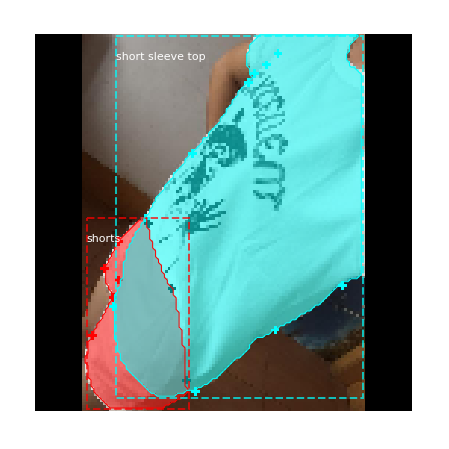

Processing 1 images
image                    shape: (128, 128, 3)         min:    0.00000  max:  254.00000  uint8
molded_images            shape: (1, 128, 128, 3)      min: -123.70000  max:  150.10000  float64
image_metas              shape: (1, 26)               min:    0.00000  max:  128.00000  int64
anchors                  shape: (1, 4092, 4)          min:   -0.71267  max:    1.20874  float32


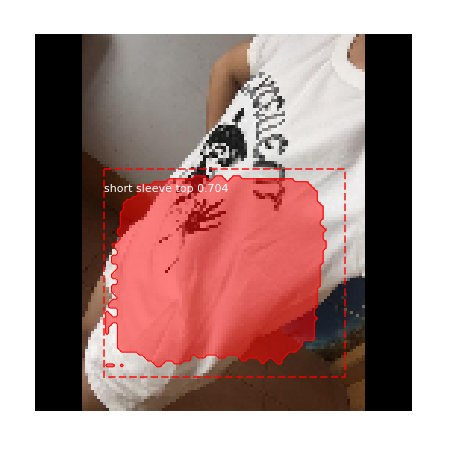

In [24]:
# Test on a random image
image_id = random.choice(dataset_val.image_ids)
original_image, image_meta, gt_class_id, gt_bbox, gt_mask, gt_landmark =\
    modellib.load_image_gt(dataset_val, inference_config, 
                           image_id, use_mini_mask=False)

log("original_image", original_image)
log("image_meta", image_meta)
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)
log("gt_landmark", gt_landmark)

visualize.display_instances(original_image, gt_bbox, gt_mask, gt_landmark, gt_class_id, 
                            dataset_train.class_names, figsize=(8, 8))

results = model.detect([original_image], verbose=2)

r = results[0]
visualize.display_instances(original_image, r['rois'], r['masks'], r['landmarks'], r['class_ids'], 
                            dataset_val.class_names, r['scores'], ax=get_ax())

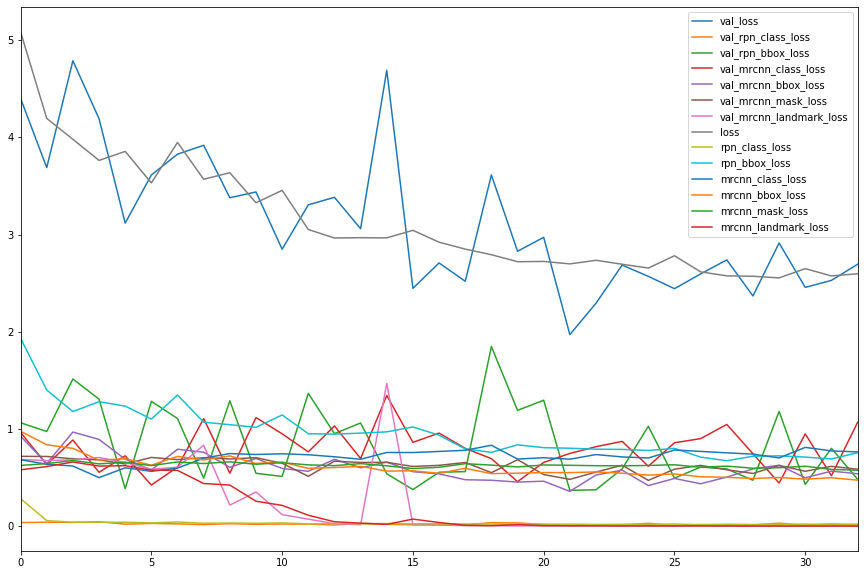

In [15]:
#Some easy visualization
import pandas as pd
import pickle

#Store the history dict
with open('./trainHistoryDict', 'wb') as file_pi:
    pickle.dump(history.history, file_pi)

#Check that it loads
train_history = pickle.load(open( "trainHistoryDict", "rb" ) )

#Convert to a dataframe
df = pd.DataFrame(train_history)

#Show evolution of metrics
fig, ax = plt.subplots(figsize = (15,10))
df.plot(ax = ax)
plt.show()


